# Обрабока распределения уровня сигнала WI-Fi пакетов

Структура и особенности выборки
* Пакеты захватывались WI-Fi картой ноутбука утилитой `tshark`.
* Из пакетов извлекались 3 параметра: временная метка, MAC адрес источника пакета, уровень сигнала (dbm).
* Пакеты в которых отсутствовал хотя бы один из параметров игнорировались.
* Уровень сигнала всегда представлен целым отрицательным числом.
* Выборки собираемые в домашних условиях записывались ночью для минимизации движений влияющих на уровень сигнала.

Для обработки были собраны выборки из 3х локаций:
* [25 этажная новостройка](../data/wifi_610k.csv)
* [панельный 9 этажный дом](../data/wifi_729k.csv)
* [радиофак](../data/wifi_52k.csv)

Подход к обработке:
* Каждая выборка содержит несколько десятков тысяч записей с разными MAC адресами.
* Mac адрес рассматривается как идентификатор устройства (есть нюансы в практической части).
* Из каждой выборки для обработки выбирались те устройства, от которых было собрано наибольшее количество записей уровня сигнала.
* Из графика уровня сигнала от времени определялся временной промежуток, в котором среднее значение и девиация уровня сигнала были наиболее стабильны.
* Для записей уровня сигнала от конкретного устройства строится распределение вероятноси уровня сигнала.
* Для полученного распределения вычисляются статистические характеристики, после чего строится 2 распределения (нормальное и Хи-квадрат) с аналогичными характеристиками.
* Для эмпирического распределения рассчитывается критерий принаджежности к распределению по методу Хи-квадрат Пирсона ([табличные значения](https://portal.tpu.ru/SHARED/s/SHAROVA/Ucheba/Tab5/Tablichnye_znacheniya_kriteriev.pdf)).

## Теоретическая часть

In [78]:
# подключение всех требуемых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

In [79]:
# прочитать выборку в структуру данных
def load_data(filename):
    try:
        data = pd.read_csv(filename, header=None, names=['timestamp', 'mac', 'rssi'])
        data['timestamp'] = pd.to_numeric(data['timestamp'])
        data['rssi'] = pd.to_numeric(data['rssi'])
        return data
    except Exception as e:
        print(f'Ошибка при загрузке данных: {e}')

# извлечь из выборки все записи, кроме n MAC адресов имеющих наибольшее количество записей
def filter_data(data, n = 5):
    mac_counts = data['mac'].value_counts()
    top_macs = mac_counts.head(n).index.tolist()
    filtered_data = data[data['mac'].isin(top_macs)].copy()
    return filtered_data

# отобразить график уровня сигнала от времени для каждого mac адреса
def plot_data(data):
    for mac in data['mac'].unique():
        mac_data = data[data['mac'] == mac].sort_values('timestamp')
        plt.plot(mac_data['timestamp'], mac_data['rssi'], label=mac)
    plt.xlabel('Timestamp')
    plt.ylabel('RSSI (dBm)')
    plt.title('Уровень сигнала по устройствам')
    plt.legend()
    plt.show()

In [80]:
# извлечь из выборки значения уровня сигнала конкретного устройства
def extract_distibution(data, mac):
    mac_data = data[data['mac'] == mac]
    if mac_data.empty:
        print(f'В выборке отсутствует MAC адрес: {mac}')
    return mac_data['rssi'].values

# разделить значения уровня сигнала по пороговому значению
def split_distribution(values, limit):
    return values[values <= limit], values[values > limit]

# отобразить распределение уровня сигнала с эталонными распределениями
def plot_distibution(values):
    def plot_raw(values):
        plt.plot(values)
        plt.title('Уровень конкретного устройства')
        plt.xlabel('Timestamp')
        plt.ylabel('RSSI (dBm)')
        plt.show()
    def plot_values(values):
        unique, counts = np.unique(values, return_counts=True)
        plt.bar(unique, counts / len(values), color='lime', label=f'RSSI данные (n={len(values)})') 
    def plot_norm(values):
        x = np.linspace(min(values), max(values), 300)
        y = sp.stats.norm.pdf(x, np.mean(values), np.std(values))
        plt.plot(x, y, label=f'Нормальное  распределение')
    def plot_chi2(values):
        shift = 1
        shifted_values = values - min(values) + shift
        df, loc, scale = sp.stats.chi2.fit(shifted_values, floc=0)
        x_chi2 = np.linspace(0, max(shifted_values), 300)
        y_chi2 = sp.stats.chi2.pdf(x_chi2, df, loc=0, scale=scale)
        x_plot = x_chi2 + min(values) - shift
        plt.plot(x_plot, y_chi2, label=f'Хи-квадрат')
    #plot_raw(values) # построить отдельный график значений уровня сигнала
    plot_values(values)
    plot_norm(values)
    plot_chi2(values)
    plt.xlabel('RSSI (dBm)')
    plt.ylabel('Вероятность')
    plt.title('Распределение уровня сигнала')
    plt.legend()
    plt.show()

In [81]:
# Вывести рассчитанные значения критериев принадлежности распределения к распределениям Хи-квадрат и нормальному распределению
def test_distribution(values):

    # Рассчет и вывод значений критериев
    def chi2(x, y1, y2, n = len(values)):
        #plt.plot(x, y1); plt.plot(x, y2); plt.show()
        print(f'Количество степеней свободы: {len(x) - 1}')
        print(f'Критерий: {np.sum((n / y2) * (y1 - y2) ** 2)}')

    # распределение вероятности эмпирической функции
    unique, counts = np.unique(values, return_counts=True)
    x_values = unique
    y_values = counts / len(values)

    # построение нормального распределения с аналогичными статистическими характеристиками
    y_norm = sp.stats.norm.pdf(x_values, np.mean(values), np.std(values))
    print('Критерий Хи2 для нормального распределения:')
    chi2(x_values, y_values, y_norm)

    # построение распределения Хи-квадрат с аналогичными статистическими характеристиками
    shift = 1
    shifted_values = values - min(values) + shift
    df, loc, scale = sp.stats.chi2.fit(shifted_values, floc=0)
    shifted_x = x_values - min(values) + shift
    y_chi2 = sp.stats.chi2.pdf(shifted_x, df, loc=0, scale=scale)
    y_chi2 = y_chi2 / np.sum(y_chi2)
    print('Критерий Хи2 для распределения Хи2:')
    chi2(x_values, y_values, y_chi2)

## Практическая часть

### Выборка из 25 этажной новостройки
* Наиболее показательная выборка.
* Изучаемым устройством является домашний роутер расположенный в 4х метрах от ноутбука.
* Роутер и ноутбук окружены большим количеством электронных устройств.
* Для каждого сетевого интерфейса роутера собрано более чем 140 тысяч значений уровня сигнала.
* Распределение похоже на чуть "искаженную" версию нормального распределения.
* Для критерия Пирсона это "искажение" является существенным при большом объеме данных.
* При децимации списка значений (в данном случае уменьшения объема данных в 500 раз) влияние "искажения" становится несущественным, что позволило бы сделать вывод о принадлежности распреденеия к нормальному

#### Распределения уровня сигнала для 140 тысяч значений

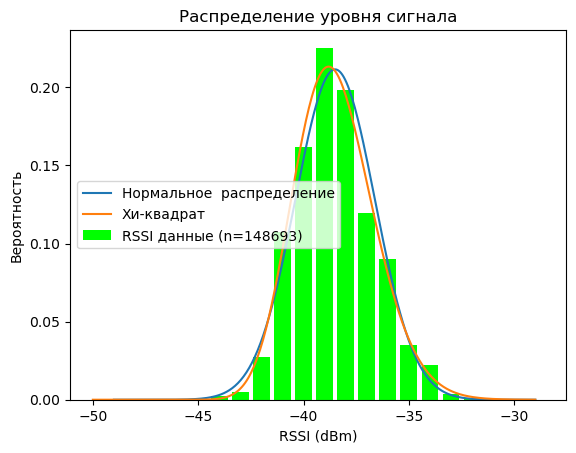

Критерий Хи2 для нормального распределения:
Количество степеней свободы: 20
Критерий: 4961.26728018753
Критерий Хи2 для распределения Хи2:
Количество степеней свободы: 20
Критерий: 9.765170065257327e+18


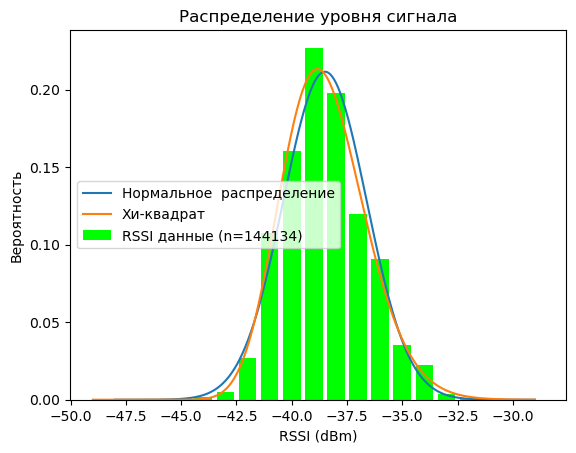

Критерий Хи2 для нормального распределения:
Количество степеней свободы: 19
Критерий: 4728.571782949805
Критерий Хи2 для распределения Хи2:
Количество степеней свободы: 19
Критерий: 58961057850889.22


In [82]:
data = filter_data(load_data('../data/wifi_610k.csv'), 3)
#plot_data(data)
values = extract_distibution(data, 'a8:29:48:20:87:23')
plot_distibution(values)
test_distribution(values)
values = extract_distibution(data, 'da:29:48:20:87:23')
plot_distibution(values)
test_distribution(values)

#### Распределения уровня сигнала для децимированного набора данных

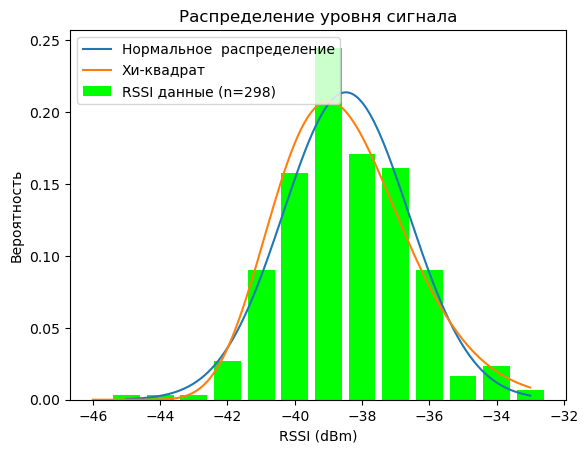

Критерий Хи2 для нормального распределения:
Количество степеней свободы: 12
Критерий: 20.187721567203656
Критерий Хи2 для распределения Хи2:
Количество степеней свободы: 12
Критерий: 36425.00459164819


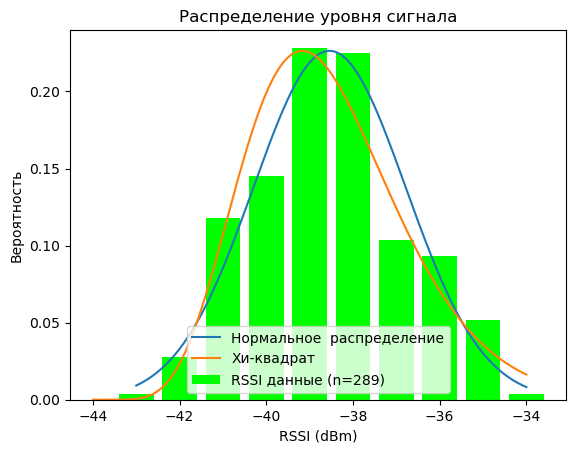

Критерий Хи2 для нормального распределения:
Количество степеней свободы: 9
Критерий: 16.229091242444543
Критерий Хи2 для распределения Хи2:
Количество степеней свободы: 9
Критерий: 19.260662726060474


In [83]:
data = filter_data(load_data('../data/wifi_610k.csv'), 3)
#plot_data(data)
values = extract_distibution(data, 'a8:29:48:20:87:23')[::500]
plot_distibution(values)
test_distribution(values)
values = extract_distibution(data, 'da:29:48:20:87:23')[::500]
plot_distibution(values)
test_distribution(values)

### Выборка из 9 этажного панельного дома
* Особенность выборки заключается в аномальном распределении уровня сигнала.
* Можно предположить, что устройством снова является роутером из-за наличия 2х похожих MAC адресов.

#### График уровня сигнала от конкретных MAC-адресов
* На графике заметно, что пакеты отправленные с MAC-адресом источника `3a:64:cf:eb:81:d1` имеют явное отличие в уровне сигнала.
* Для нормальной маршрутизации каждое устройство в сети должно иметь различный MAC адрес.
* Мне неизвестно о технологиях, переиспользующих один MAC адрес, при этом не являющихся сетевой аткой.
* Стоит отметить, что сигнал от "дополнительного источника" появляется резко с некоторой периодичностью, имеет меньший уровень и существует параллельно "основному устройству".

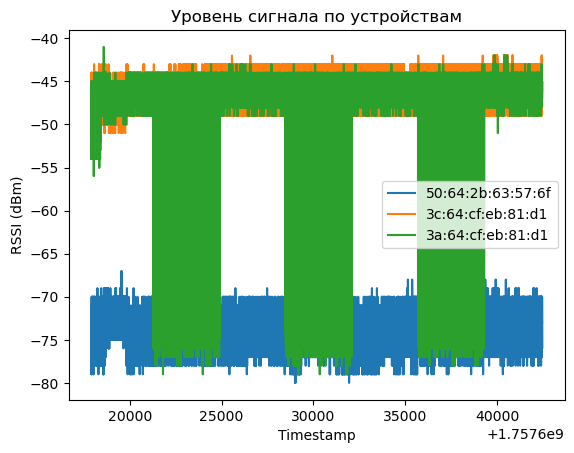

In [84]:
data = filter_data(load_data('../data/wifi_729k.csv'), 3)
plot_data(data)

#### Сетевой интерфейс имеющий аномальное распределение
* На распределении сигнала видно даже 3 явно выделяющихся источника.
* Дополнительные источники имеют меньший уровень сигнала в точке захвата пакетов.
* Количество и вид препядствий между источником сигнала и приемником (ноутбуком) неизвестно (минимум стена).
* Источники сигнала были разделены по пороговым значениям -65 и -50 dbm.
* При расчете принадлежности распределений проявляется аналогичная предыдущей выборке проблема.
* При большом количестве данных "искажение" нормального распределения является критическим для используемого метода.
* При проряживании данных можно было бы сделать вывод  о принадлежности распределения к нормальному.

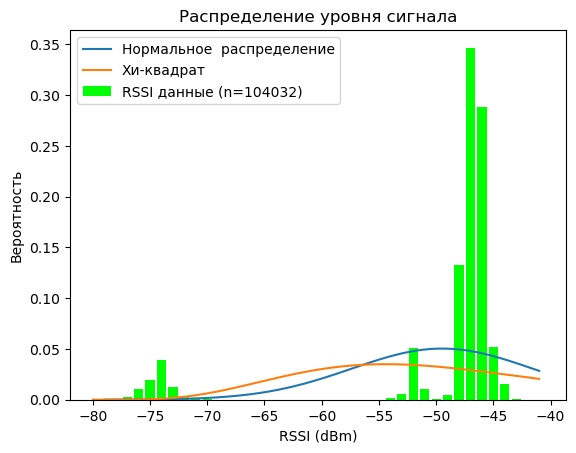

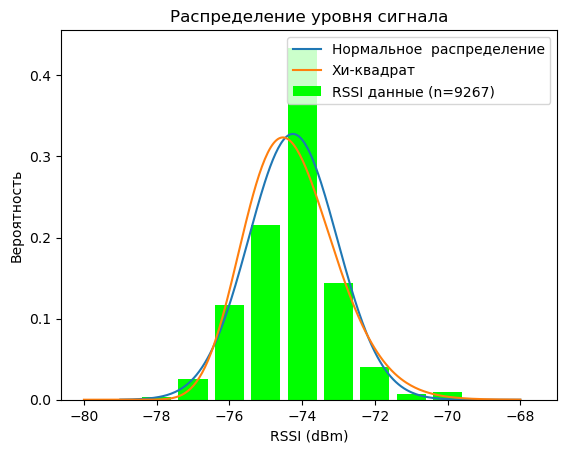

Критерий Хи2 для нормального распределения:
Количество степеней свободы: 11
Критерий: 2170.8339702355092
Критерий Хи2 для распределения Хи2:
Количество степеней свободы: 11
Критерий: 648726.0571284704


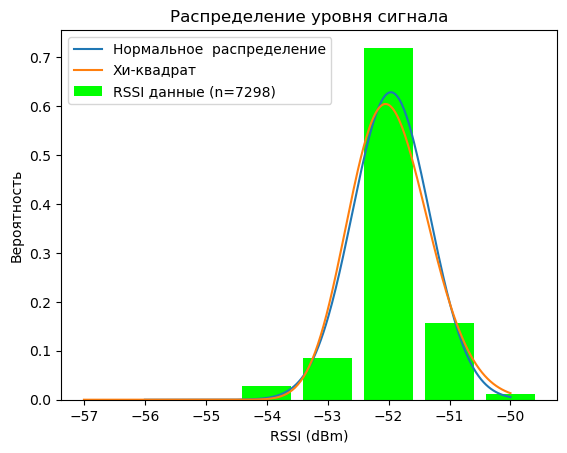

Критерий Хи2 для нормального распределения:
Количество степеней свободы: 6
Критерий: 132008.53848490719
Критерий Хи2 для распределения Хи2:
Количество степеней свободы: 6
Критерий: 9343894629463172.0


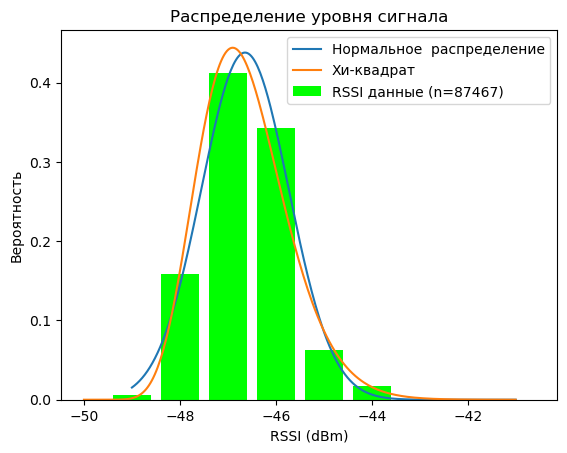

Критерий Хи2 для нормального распределения:
Количество степеней свободы: 8
Критерий: 279332.27563306614
Критерий Хи2 для распределения Хи2:
Количество степеней свободы: 8
Критерий: 2305.178229981059


In [85]:
values = extract_distibution(data, '3a:64:cf:eb:81:d1')
plot_distibution(values)

values, temp = split_distribution(values, -65)
plot_distibution(values)
test_distribution(values)

values, temp = split_distribution(temp, -50)
plot_distibution(values)
test_distribution(values)

values = temp
plot_distibution(values)
test_distribution(values)


#### Сетевой интерфейс имеющий ожидаемое распределение

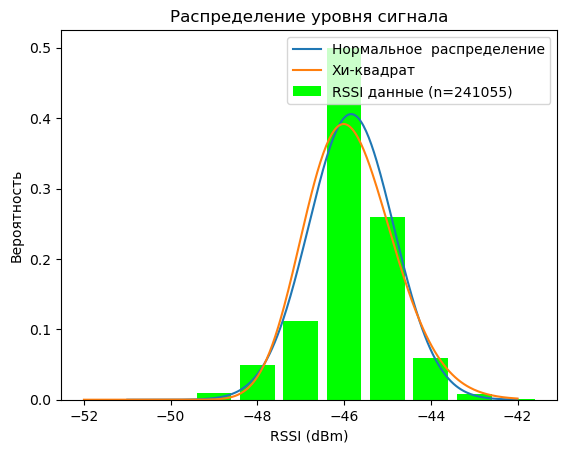

Критерий Хи2 для нормального распределения:
Количество степеней свободы: 9
Критерий: 29906.11002995306
Критерий Хи2 для распределения Хи2:
Количество степеней свободы: 9
Критерий: 1427394995269.2312


In [86]:
values = extract_distibution(data, '3c:64:cf:eb:81:d1')
plot_distibution(values)
test_distribution(values)

### Выборка из Радиофака
* Выборка записана во время лекции.
* Сложно предположить чем в действительности является источник сигнала.
* Изменения могут быть вызваны как и физическим перемещением устройства с включенной точкой доступа, так и изменением количества пряпятствий между источником сигнала и приемником.
* Данные выборки можно легко обрезать взяв из них временные промежутки, в которых изменение среднего значения уровня сигнала минимально. Это намеренно не было сделано.
* Подобного рода изменения уровня сигнала сильно влияют на его распределение. Даже при применении децимации нельзя сделать вывод о том, что сигнал относится к ранее описанным распределениям.
* Возможно есть смысл отдельно изучить распределение уровня сигнала от движущегося источника или в ситуации когда между примеником и передатчиком появляется перекрытие.

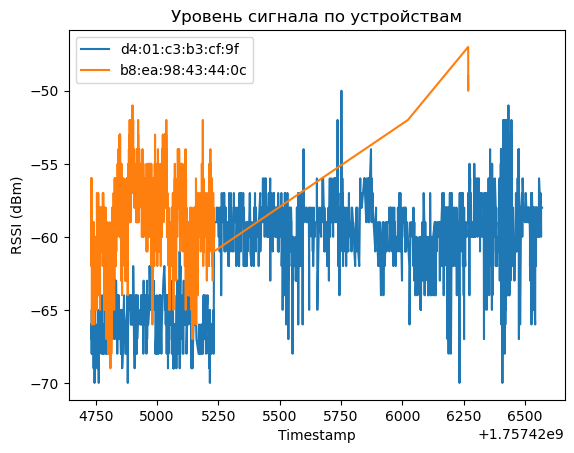

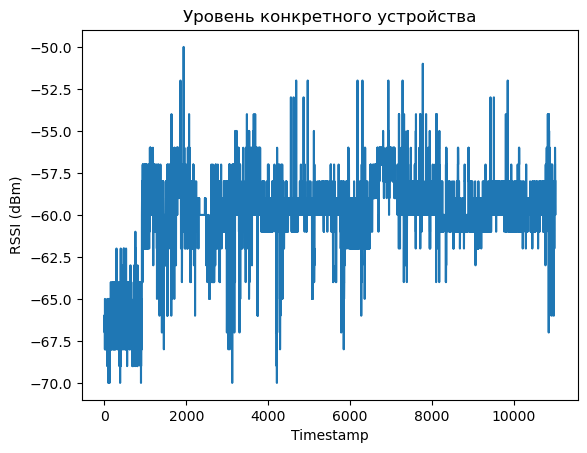

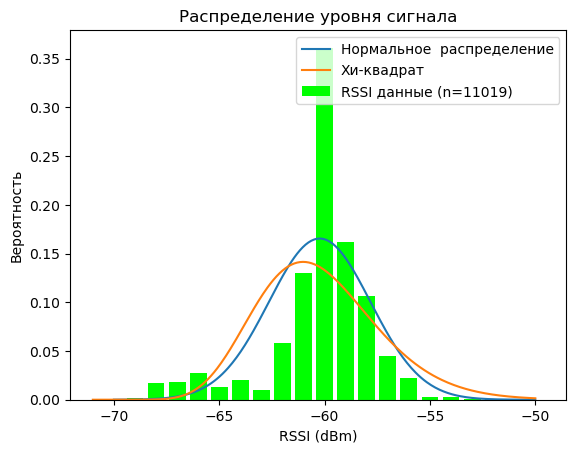

Критерий Хи2 для нормального распределения:
Количество степеней свободы: 20
Критерий: 8640.69464538221
Критерий Хи2 для распределения Хи2:
Количество степеней свободы: 20
Критерий: 2169521.1725832657


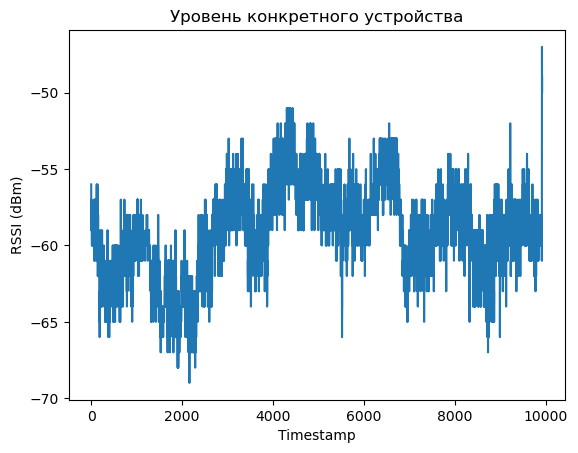

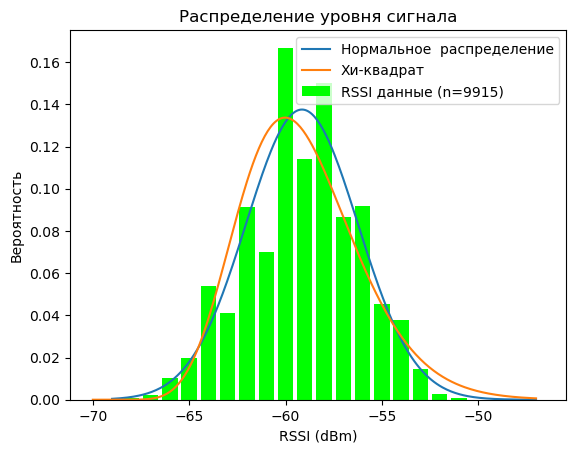

Критерий Хи2 для нормального распределения:
Количество степеней свободы: 22
Критерий: 651.6333914466074
Критерий Хи2 для распределения Хи2:
Количество степеней свободы: 22
Критерий: 7396.675296294018


In [77]:
data = filter_data(load_data('../data/wifi_52k.csv'), 2)
plot_data(data)
values = extract_distibution(data, 'd4:01:c3:b3:cf:9f')
plot_distibution(values)
test_distribution(values)
values = extract_distibution(data, 'b8:ea:98:43:44:0c')
plot_distibution(values)
test_distribution(values)